# AST 384C - Computational Astrophysics - HW 3
## Carlos Jurado

In [1]:
# Python package imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt 

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

# Problem 1: Non-Gaussian Samplers

Problem 9 From Hogg & Foreman-Mackey (2018): 

Modify the sampler you wrote in Problem 2 to take steps not in x but in xln . That is, replace the Gaussian proposal distribution q x x ¢( ∣ ) with a Gaussian distribution in xlnq x x ln ln¢( ∣ ), but make no other changes. By doing this, you are no longer sampling the Gaussian p(x)that you were in Problem 2. What about your answers changes? What distribution are you sampling now? Compute the analytic function that you have sampled from—this will no longer be the same p(x) and overplot it on your histogram. The solution to this problem is shown in Figure 4.

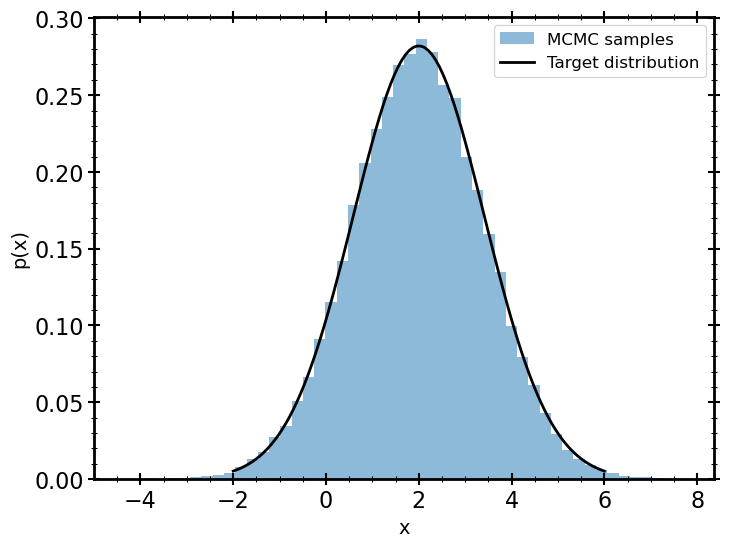

In [2]:
def target(x, mean=2, sigma=np.sqrt(2) ):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5* (x-mean)**2/(sigma**2))

def proposal(x):
    return random.normal(x,1)

def acceptance_ratio(x, x_new):
    return target(x_new)/target(x)

def mcmc(x0, n_samples):
    samples = np.zeros(n_samples)
    samples[0] = x0
    for i in range(1, n_samples):
        x_new = proposal(samples[i-1])
        uni = random.uniform(0, 1)
        if acceptance_ratio(samples[i-1], x_new) > uni:
            samples[i] = x_new
        else:
            samples[i] = samples[i-1]
    return samples

x0 = 0
n_samples = 100000
samples = mcmc(x0, n_samples)


# Plot the results
plt.clf()
plt.hist(samples, bins=50, density=True, alpha=0.5, label='MCMC samples')
x = np.linspace(-2, 6, 100)
plt.plot(x, target(x), label='Target distribution', color='black')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

# Problem 2: Convergence

Do problem 10 from Hogg & Foreman-Mackey (2018): Redo Problem 2, but now look at convergence: 

Plot the x chain as a function of time step. Also split the chain into four contiguous segments (the first, second, third, and fourth quarters of the chain). In each of these four, compute the empirical mean and empirical variance of x. What do you conclude about convergence from these heuristics?

In [3]:
######################################################  Code For Problem 2 Begins Here #################################### 

def target(x, mean=2, sigma=np.sqrt(2) ):
    ''' 
    Gaussian target function that we wish to sample from 

    Parameters
        x: Current value 
        mean: Mean value of the gaussian
        sigma: Standard deviation of the gaussian 

    returns: float value

    '''
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5* (x-mean)**2/(sigma**2))

def proposal(x):
    '''  
    Proposal distribution from which to sample a new point from given the current point

    Parameters
        x: Current position 

    returns: float value
    
    '''
    return random.normal(x,1)

def acceptance_ratio(x, x_new):
    return target(x_new)/target(x)

def mcmc(x0, n_samples):
    samples = np.zeros(n_samples) # Initializes a fixed numpy array 
    samples[0] = x0 # Assigns the starting value as the first value in the chain
    for i in range(1, n_samples):
        x_new = proposal(samples[i-1]) # proposes a new value based on the current location
        uni = random.uniform(0, 1) # sample one point from a uniform distribution
        if acceptance_ratio(samples[i-1], x_new) > uni: # Metropolis-Hastings Implementation
            samples[i] = x_new
        else:
            samples[i] = samples[i-1]
    return samples

x0 = 0
n_samples = 100000
samples = mcmc(x0, n_samples)
######################################################  Code For Problem 2 Ends Here #################################### 

Text(0, 0.5, 'x')

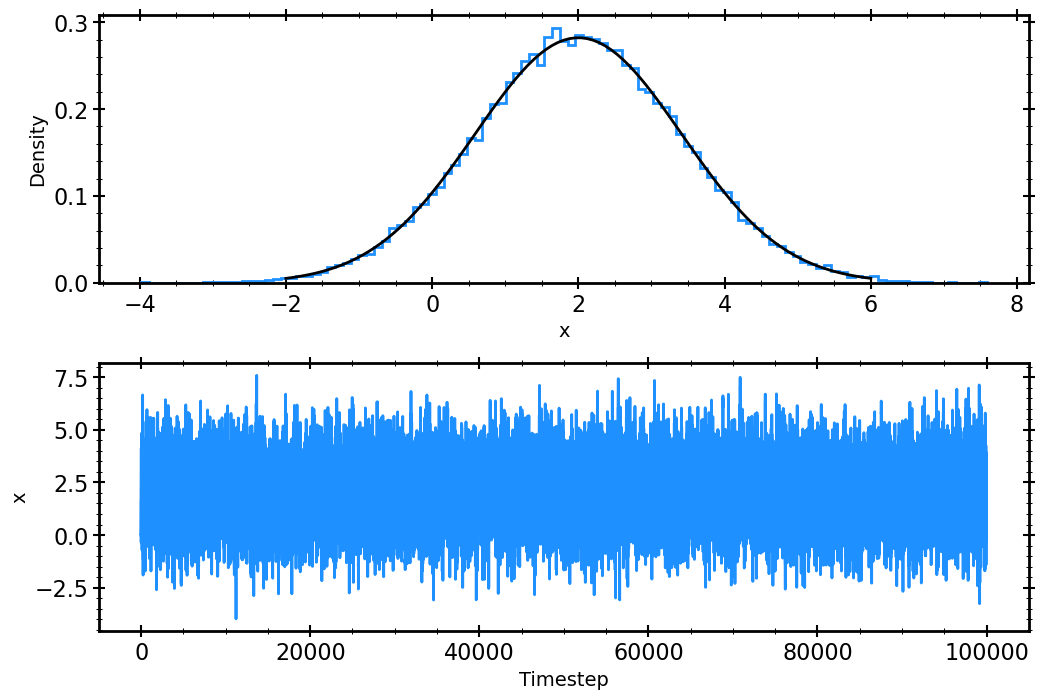

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3)


axs[0].hist(samples, color='dodgerblue', bins='scott', histtype='step', density=True, lw=2)
axs[0].plot(x, target(x), color='black', lw=2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Density')

axs[1].plot(samples, color='dodgerblue')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('x')

In [5]:
quarter = 25000

intervals_arr = [samples[0:quarter], samples[quarter:2*quarter], 
                 samples[2*quarter:3*quarter], samples[3*quarter:]]

i = 1
for arr in intervals_arr:
    print(f'\nMean of quarter {i} is: {np.round(np.mean(arr),2)} ')
    print(f'Variance of quarter {i} is: {np.round(np.var(arr),2)} ')
    print('=====================================')
    i += 1


Mean of quarter 1 is: 1.98 
Variance of quarter 1 is: 2.02 

Mean of quarter 2 is: 2.04 
Variance of quarter 2 is: 1.95 

Mean of quarter 3 is: 2.01 
Variance of quarter 3 is: 1.99 

Mean of quarter 4 is: 1.97 
Variance of quarter 4 is: 2.0 


The values of the mean and variance for the quarters suggest that even with only 25,000 steps, the mcmc converges on the true mean and variance values of the distribution function. 

# Problem 3: Autocorrelation
Do problem 11 from Hogg & Foreman-Mackey. Repeat the exercise using a proposal distribution that has a variance two times larger, and again with a variance that is two times smaller than what is given in the original problem. How does the autocorrelation function change (and why)?

Problem 11. Write a piece of code that computes the empirical
autocorrelation function. You will probably want to speed this
computation up by using a fast Fourier transform.37 Run this on
the chain you obtained from Problem 2. Plot the autocorrelation
function you find at short lags (Δ<100). This plot should
resemble Figure 5

From Wikipeida, "For a discrete process with known mean and variance for which we observe n observations $ \{X_1, X_2,..., X_n\}$, an estimate of the autocorrelation coefficient may be obtained as":

$$ 
R(k) = \frac{1}{(n-k)\sigma^2} \sum_{t=1}^{n-k} (X_t - \mu)(X_{t+k} +\mu)
$$

where k is the lag, $\mu$ is the mean, and $\sigma$ is the variance. 

The Wiener-Khinchin theorem states that the autocorrelation function of a stationary time series is the inverse fourier transform of its power spectral density. The power spectral density is just the squared magnitude of the original fourier transform. Therefore, I can calculate the autocorrelation function directly from the fourier transform. 


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


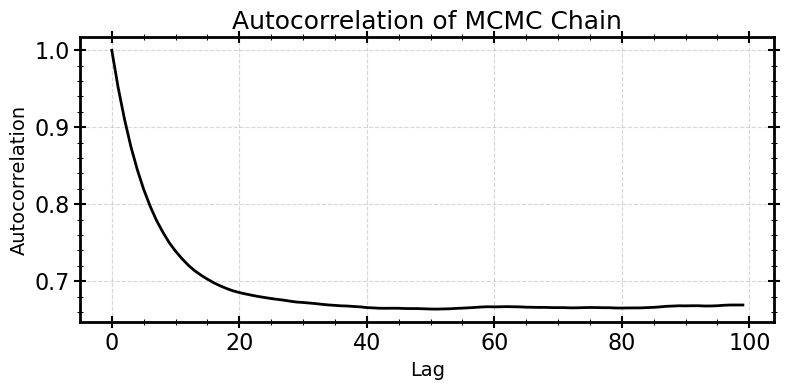

In [6]:
def autocorrelation(samples):
    ''' 
    Calculates the autocorrelation function from MCMC samples using FFTs

    Parameters:
        - val: An array of MCMC samples

    Returns: (array)
    '''

    fft = np.fft.fft(samples) #calculates the fourier transform of the mcmc samples
    power_spectrum = fft * np.conjugate(fft) # computes the power spectrum
    autocorrelation_function = np.fft.ifft(power_spectrum) # calculates the inverse fourier transform of the power spectrum

    return autocorrelation_function



# Calculate and plot ACF
autocorrelation_values = autocorrelation(samples)
autocorrelation_values_normalized = autocorrelation_values/autocorrelation_values[0]

plt.figure(figsize=(8, 4))
plt.plot(autocorrelation_values_normalized[:100], color = 'black', linewidth=2) 
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of MCMC Chain")
plt.grid(True)
plt.tight_layout()
plt.show()
